In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import ta
import matplotlib.pyplot as plt

In [3]:
df = yf.download(['SMIN.L'], start='2022-01-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
df['HighBand'] = ta.volatility.keltner_channel_hband(df.High, df.Low, df.Close, original_version=False)
df['MiddleBand'] = ta.volatility.keltner_channel_mband(df.High, df.Low, df.Close, original_version=False)
df['LowBand'] = ta.volatility.keltner_channel_lband(df.High, df.Low, df.Close, original_version=False)

df['rsi'] = ta.momentum.rsi(df.Close, window=6)

In [5]:
df

,Open,High,Low,Close,Adj Close,Volume,HighBand,MiddleBand,LowBand,rsi
Date,,,,,,,,,,
2022-01-04,1593.0,1624.000000,1590.000000,1620.0,1576.837891,1010355,NaN,NaN,NaN,NaN
2022-01-05,1617.0,1628.500000,1614.017944,1626.5,1583.164673,963016,NaN,NaN,NaN,NaN
2022-01-06,1604.5,1626.098999,1596.500000,1598.0,1555.424072,762407,NaN,NaN,NaN,NaN
2022-01-07,1595.0,1604.500000,1580.000000,1599.0,1556.397461,865550,NaN,NaN,NaN,NaN
2022-01-10,1603.5,1615.000000,1584.000000,1593.0,1550.557251,791276,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-01-10,1620.0,1631.000000,1615.000000,1628.0,1628.000000,530269,1656.325007,1608.314125,1560.303243,67.381966
2023-01-11,1621.0,1637.000000,1621.000000,1631.0,1631.000000,944197,1656.884478,1610.474684,1564.064891,69.706130
2023-01-12,1635.0,1644.175049,1623.500000,1632.0,1632.000000,1055143,1658.428539,1612.524714,1566.620890,70.545627


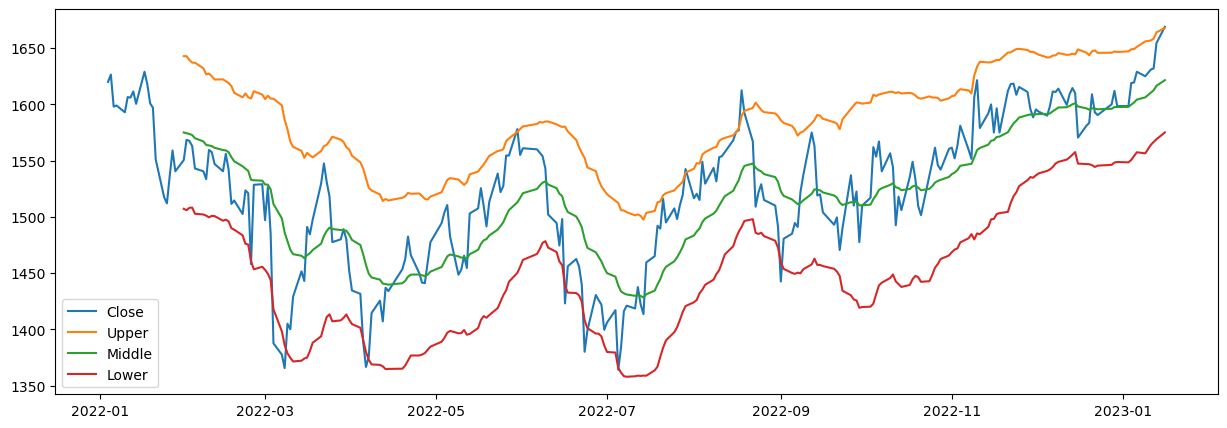

In [6]:
plt.figure(figsize=(15,5))
plt.plot(df['2022':][['Close', 'HighBand', 'MiddleBand', 'LowBand']], label=['Close', 'Upper', 'Middle', 'Lower'])
#plt.fill_between(df.index, df.HighBand, df.LowBand, color='grey', alpha=0.3)
plt.legend(loc='lower left')

In [7]:
conditions = [(df.rsi < 30) & (df.Close < df.LowBand),
              (df.rsi > 70) & (df.Close > df.HighBand)]
choices = ['Buy', 'Sell']

df['signal'] = np.select(conditions, choices)

In [8]:
df.dropna(inplace=True)

In [9]:
df.signal = df.signal.shift()
df['shifted_close'] = df.Close.shift()

In [16]:
position = False

buydate, selldate = [], []
buyprice, sellprice = [], []

for index, row in df.iterrows():
    if not position:
        if row['signal'] == 'Buy':
            buydate.append(index)
            buyprice.append(row.Open)
            position = True
    if position:
        if row['signal'] == 'Sell':# or row.shifted_close < 0.95 * buyprice[-1]:
            selldate.append(index)
            sellprice.append(row.Open)
            position = False

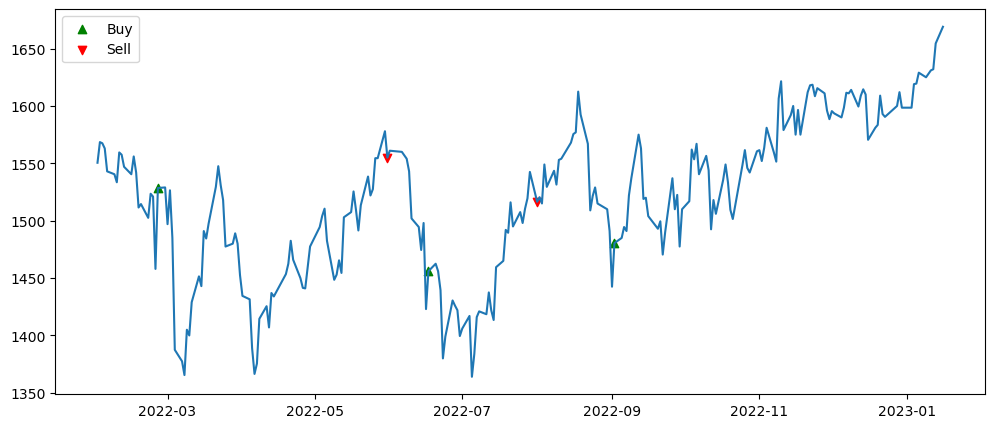

In [17]:
plt.figure(figsize=(12, 5))
plt.plot(df.Close)
plt.scatter(df.loc[buydate].index, df.loc[buydate].Close, marker='^', color='g', label = 'Buy')
plt.scatter(df.loc[selldate].index, df.loc[selldate].Close, marker='v', color='r', label = 'Sell')
plt.legend(loc='upper left')

In [18]:
MeanReversion = (pd.Series([(sell - buy) / buy for sell,buy in zip(sellprice, buyprice)]) + 1).prod()
buyHold = (df['Adj Close'].pct_change() + 1).prod()

print(f'Mean Reversion: {round(MeanReversion,2)}\nBuy/hold: {round(buyHold,2)}\nDifference: {round(MeanReversion - buyHold,2)}')

Mean Reversion: 1.15
Buy/hold: 1.11
Difference: 0.04
